# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

simulation_files_old = [
    'grenoble_2019-01-10_1838722.zip',
    'grenoble_2019-01-10_1838724.zip',
    'grenoble_2019-01-10_1838726.zip',
]
simulation_files = [
    'grenoble_2019-01-28_1844147.zip',
    'grenoble_2019-01-28_1844150.zip',
    'grenoble_2019-01-28_1844153.zip',
    'grenoble_2019-01-28_1844154.zip',
]
reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
dfsim = pandas.concat([read_result(f) for f in simulation_files])
dfsim_old = pandas.concat([read_result(f) for f in simulation_files_old])
dfreal = pandas.concat([read_result(f) for f in reality_files])
dfsim_old['mode'] = 'simulation:old'
dfsim['mode'] = 'simulation:new'
dfreal['mode'] = 'reality'
df = pandas.concat([dfsim, dfsim_old, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,proc_q,process_per_node,residual,rfact,simulation_time,swap,sys_time,thread_per_process,time,usr_time
0,1657.300,2,128,0.99,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,26700.0,...,32,32,NaN,2,15557.80,0,3516.95,1,2275.05,12006.66
1,889.522,2,128,0.99,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,24670.0,...,32,32,NaN,2,7458.10,0,1378.72,1,422.30,6065.93
2,556.856,2,128,0.99,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,21430.0,...,32,32,NaN,2,4164.01,0,525.34,1,104.99,3631.46
3,208.440,2,128,1.00,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,8976.0,...,32,32,NaN,2,1327.58,0,112.75,1,9.28,1216.10
0,653.196,2,128,0.99,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,22580.0,...,32,32,NaN,2,5092.99,0,712.03,1,158.24,4373.25


### Checking the parameters

In [2]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,6.484604e-11,0.000001,8.021068e-11,6.929164e-07


In [3]:
dfsim_old[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,6.484604e-11,0.000001,8.021068e-11,6.929164e-07


In [4]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,pfact,depth,thread_per_process,rfact,swap,proc_p,bcast,block_size,process_per_node,proc_q,mem_align
0,1,1,1,2,0,32,2,128,32,32,8


In [5]:
platforms = [zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in (simulation_files + simulation_files_old)]
assert(len(set(platforms))) == 1
print(platforms[0])

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

### Checking the patch in the new simulation

In [6]:
import yaml
repos = sum([yaml.load(zipfile.ZipFile(f).read('info.yaml').decode('ascii'))['git_repositories'] for f in simulation_files], [])
repos = [rep for rep in repos if 'hpl' in rep['url']]
assert len(repos) == len(simulation_files)  # one per archive
patch = set(rep['patch'] for rep in repos)
assert len(patch) == 1  # same patch for both experiments
print(patch.pop())


diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 


### Comparing the simulation with the real execution

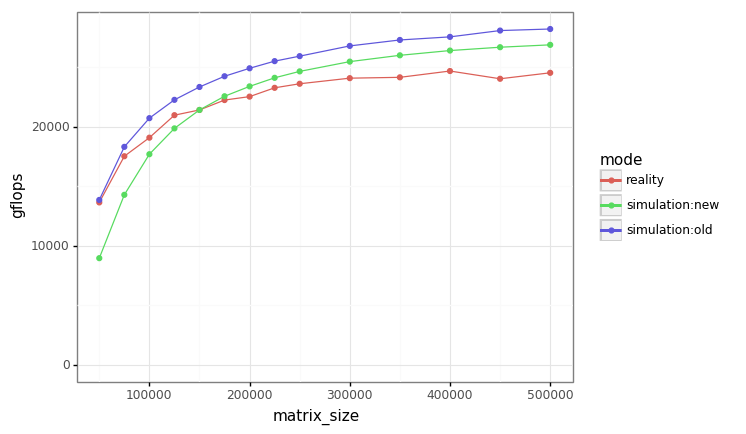

<ggplot: (8786600913693)>

In [7]:
import numpy
ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

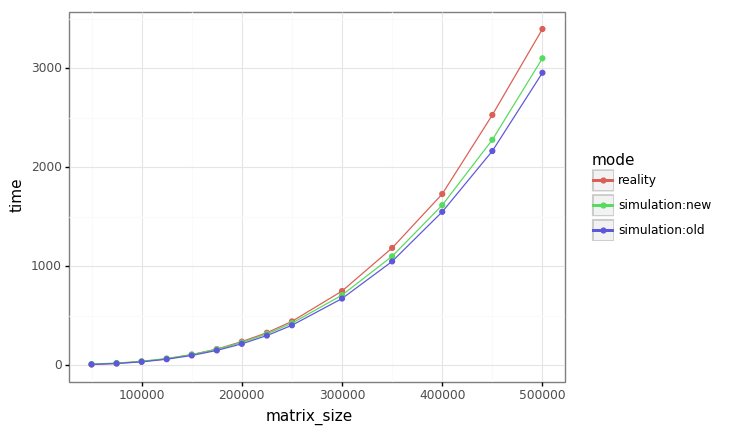

<ggplot: (8786600913847)>

In [8]:
ggplot(df, aes(x='matrix_size', y='time', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

In [9]:
dfsim[dfsim.matrix_size == dfsim.matrix_size.max()][['matrix_size', 'gflops', 'time', 'simulation_time', 'mode']]

,matrix_size,gflops,time,simulation_time,mode
3,500000,26900.0,3098.27,17991.3,simulation:new


In [10]:
dfsim_old[dfsim_old.matrix_size == dfsim_old.matrix_size.max()][['matrix_size', 'gflops', 'time', 'simulation_time', 'mode']]

,matrix_size,gflops,time,simulation_time,mode
0,500000,28230.0,2952.34,16005.8,simulation:old


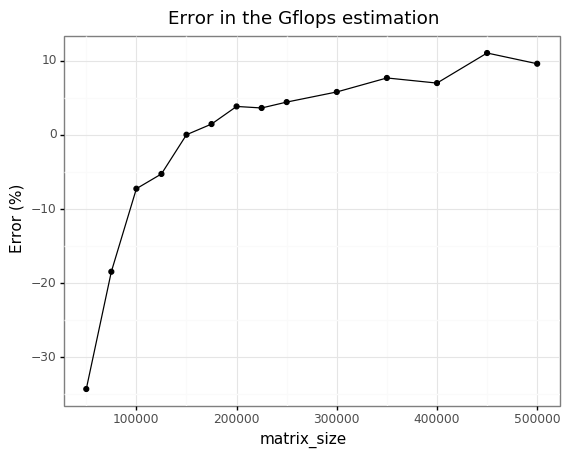

<ggplot: (8786636626724)>

In [11]:
tmp = dfsim.set_index('matrix_size').join(dfreal.set_index('matrix_size'), rsuffix='_real').reset_index()
tmp['error'] = (tmp.gflops - tmp.gflops_real) / tmp.gflops_real * 100
tmp = tmp[~tmp.error.isna()]
ggplot(tmp, aes(x='matrix_size', y='error')) + geom_line() + geom_point() + ylab('Error (%)') + ggtitle('Error in the Gflops estimation') + theme_bw()

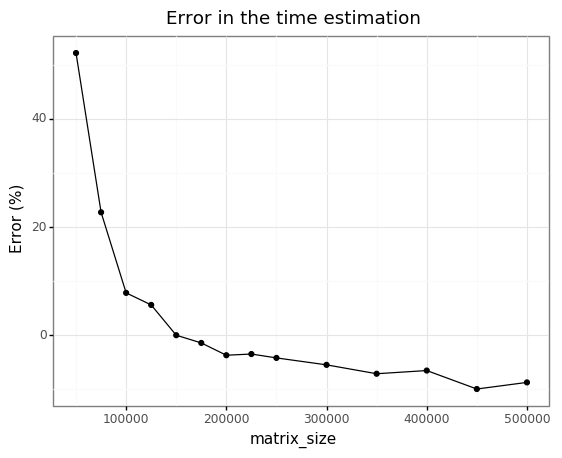

<ggplot: (8786599728637)>

In [12]:
tmp['error'] = (tmp.time - tmp.time_real) / tmp.time_real * 100
tmp = tmp[~tmp.error.isna()]
ggplot(tmp, aes(x='matrix_size', y='error')) + geom_line() + geom_point() + ylab('Error (%)') + ggtitle('Error in the time estimation') + theme_bw()

### Efficiency of the simulation

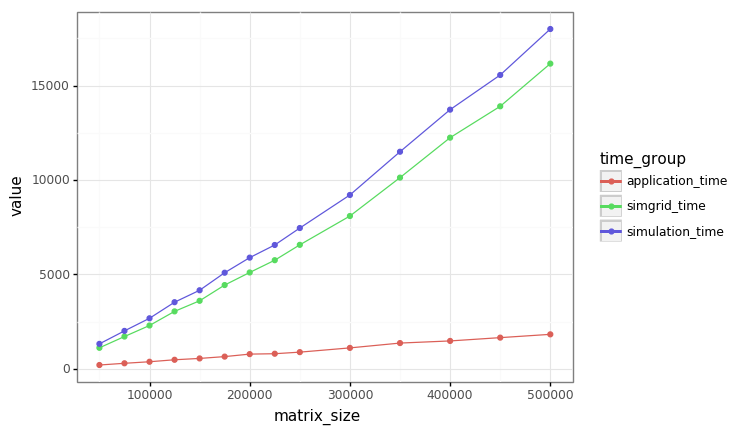

<ggplot: (8786599674102)>


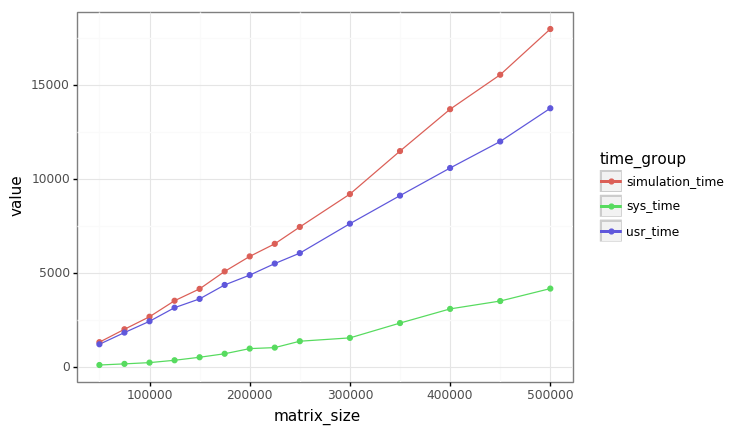

<ggplot: (-9223363250255008340)>

In [13]:
dfsim['simgrid_time'] = dfsim.simulation_time - dfsim.application_time

print(ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'application_time', 'simgrid_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw())

ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'usr_time', 'sys_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw()

### Maximum performance

In [14]:
dfsim[dfsim.gflops == dfsim.gflops.max()]

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,process_per_node,rfact,simulation_time,swap,sys_time,thread_per_process,time,usr_time,mode,simgrid_time
3,1831.47,2,128,0.99,1,6.484604e-11,0.000001,8.021068e-11,6.929164e-07,26900.0,...,32,2,17991.3,0,4179.12,1,3098.27,13773.56,simulation:new,16159.83


In [15]:
dfreal[dfreal.gflops == dfreal.gflops.max()]

,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time,mode
2,2,128,1,24700.0,400000,8,1,32,32,32,0.000531,2,0,1,1727.64,reality
